<a href="https://colab.research.google.com/github/chalothon/BERT_from_colab/blob/master/Transformer_language_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://www.tensorflow.org/tutorials/text/transformer?hl=th&fbclid=IwAR0qq3eXmLptECz0W4rLaIelc8beyFEa9XTu-t92qRNasmTedPBgXq59NqQ
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt


examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Create a custom subwords tokenizer from the training dataset.


In [0]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [7]:
sample_string = 'Transformer is awesome.'
tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))
assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.


In [8]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target.

In [0]:
def encode (lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
  return lang1, lang2

In [0]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])
  return result_pt, result_en

In [0]:
MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,tf.size(y) <= max_length)

In [0]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))    

In [0]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [0]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE))

Get an batch from the validation set to test the code on later:

In [18]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

**Positional encoding**
Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:,np.newaxis],
                          np.arange(d_model)[np.newaxis,:],
                          d_model)
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)


tf.Tensor(
[[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  1.0000000e+00
    0.0000000e+00  1.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  8.2843077e-01 ...  1.0000000e+00
    1.0242752e-04  1.0000000e+00]
  [ 9.0929741e-01 -4.1614684e-01  9.2799401e-01 ...  1.0000000e+00
    2.0485504e-04  1.0000000e+00]
  ...
  [-6.1604047e-01  7.8771454e-01  4.6585545e-01 ...  9.9991399e-01
    1.2803091e-02  9.9991804e-01]
  [ 3.2999083e-01  9.4398415e-01 -4.7212428e-01 ...  9.9991262e-01
    1.2905509e-02  9.9991673e-01]
  [ 9.7263008e-01  2.3235910e-01 -9.9472100e-01 ...  9.9991125e-01
    1.3007929e-02  9.9991542e-01]]], shape=(1, 128, 768), dtype=float32)


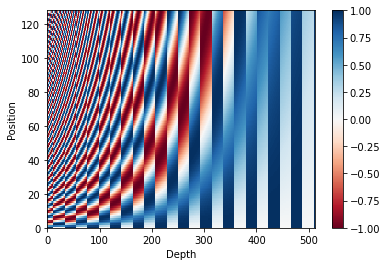

In [34]:
pos_encoding = positional_encoding(128, 768)
print (pos_encoding)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()